In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import fitsio
from scipy.interpolate import interp1d

# Mask

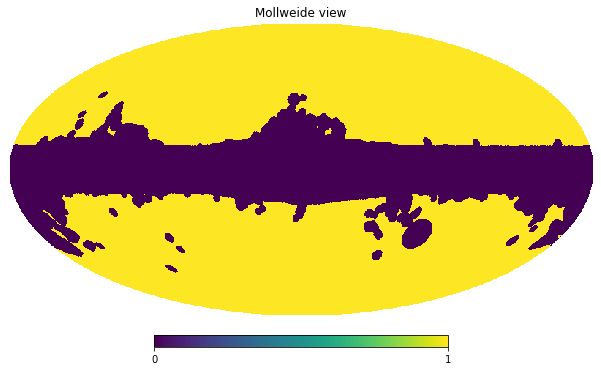

In [2]:
mask = hp.read_map("data/WISExSCOSmask.fits.gz")
hp.mollview(mask)
nside = hp.npix2nside(mask.size)

# 2MPZ

In [3]:
d2mpz = fitsio.read("data/2MPZ.fits", columns=['ZPHOTO', 'L', 'B'])

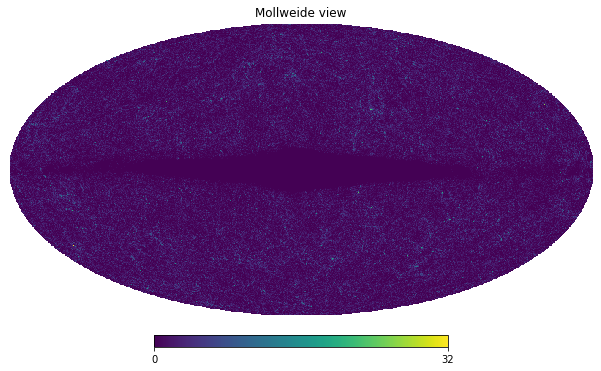

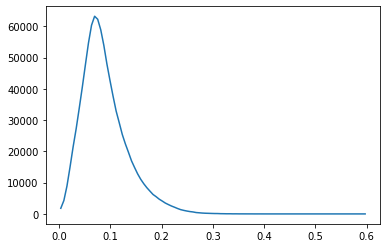

In [4]:
dndz_2mpz, zedg = np.histogram(d2mpz['ZPHOTO'], bins=100, range=[0., 0.6])
nmap_2mpz = np.bincount(hp.ang2pix(nside, d2mpz['L'], d2mpz['B'], lonlat=True), minlength=mask.size)
hp.mollview(nmap_2mpz)
plt.figure()
plt.plot(0.5*(zedg[1:]+zedg[:-1]), dndz_2mpz)

# WIxSC

In [5]:
dwisc = fitsio.read("data/WIxSC.fits", columns=['L', 'B', 'ZPHOTO_CORR'])

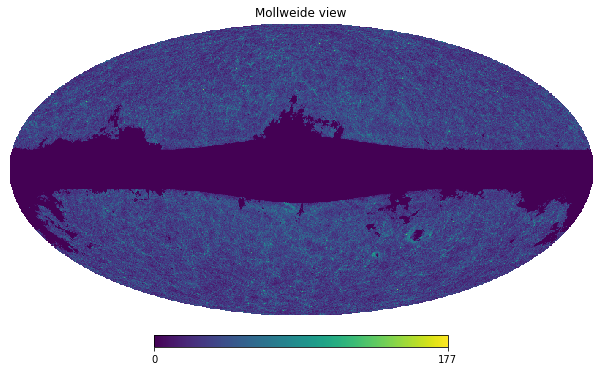

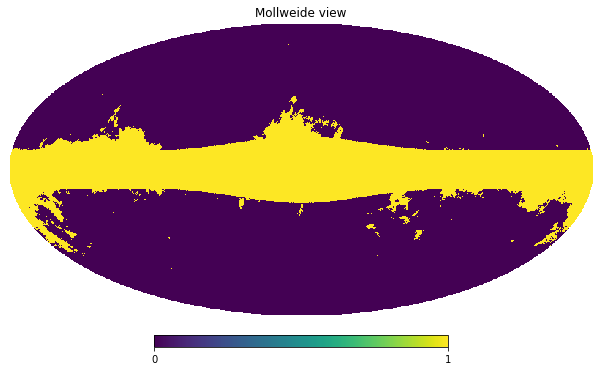

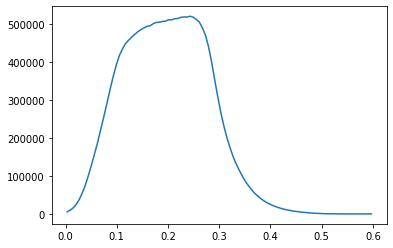

In [6]:
dndz_wisc, zedg = np.histogram(dwisc['ZPHOTO_CORR'], bins=100, range=[0., 0.6])
nmap_wisc = np.bincount(hp.ang2pix(nside, dwisc['L'], dwisc['B'], lonlat=True), minlength=mask.size)
hp.mollview(nmap_wisc)
nempty = nmap_wisc == 0
hp.mollview(nempty)
plt.figure()
plt.plot(0.5*(zedg[1:]+zedg[:-1]), dndz_wisc)

# Overdensity maps

In [7]:
nbins = 14
stars = hp.ud_grade(hp.read_map("data/allwise_total_galactic_1024.fits"),
                    nside_out=nside)
stbins = np.linspace(np.log10(stars[mask > 0].min()),
                     np.log10(stars[mask > 0].max()), nbins+1)

def get_galactic_correction(delta, npoly=3):
    d_mean = []
    d_std = []
    # Loop over bins and compute <delta> and std(delta) in each star bin
    for ib, st in enumerate(stbins[:-1]):
        stp1 = stbins[ib+1]
        msk = mask > 0
        msk *= np.log10(stars) <= stp1
        msk *= np.log10(stars) >= st
        dm = np.mean(delta[msk])
        dn = np.sum(msk).astype(float)
        ds = np.std(delta[msk])/np.sqrt(dn)
        d_mean.append(dm)
        d_std.append(ds)
    d_mean = np.array(d_mean)
    d_std = np.array(d_std)
    # Now create a 3-rd order polynomial fitting these data
    stmid = 0.5*(stbins[1:]+stbins[:-1])
    params = np.polyfit(stmid, d_mean, npoly, w=1./d_std)
    df = np.poly1d(params)
    # Create correction map
    d_corr = np.zeros_like(delta)
    d_corr[mask > 0] = df(np.log10(stars[mask > 0]))
    return {'stars': stmid,
            'delta_mean': d_mean,
            'delta_std': d_std,
            'delta_func': df,
            'delta_map': d_corr}

def get_delta(nmap, smooth=None, correct=False):
    nmean = np.average(nmap, weights=mask)
    igood = mask > 0
    delta = nmap/nmean - 1
    delta[nempty] = 0

    if smooth is not None:
        delta = hp.smoothing(delta, sigma=np.radians(smooth/2.355))

    if correct:
        d = get_galactic_correction(delta)
        hp.mollview(d['delta_map'], title='Correction')
        delta -= d['delta_map']

    delta *= mask
    hp.mollview(delta, title='delta')
    return mask*delta

In [8]:
def generate_delta_from_catalogs(cats, weighted=False, smooth=None, correct=False, prefix=None):
    znames = [np.array(cat.dtype.names)[np.array([('Z' in k) for k in cat.dtype.names])][0]
              for cat in cats]
    # Compute dN/dz
    nz = np.zeros(100)
    plt.figure()
    for n, c in zip(znames, cats):
        h, zedg = np.histogram(c[n], bins=100, range=[0, 0.5])
        zmid = 0.5*(zedg[1:]+zedg[:-1])
        plt.plot(zmid, h)
        nz += h
    zmid = 0.5*(zedg[1:]+zedg[:-1])

    # Get weights if needed
    plt.plot(zmid, nz, 'k--')
    if weighted:
        # We assume that dOmega/dr is basically constant
        ws = np.amax(nz)/nz
        zs_ok = zmid[nz > 0.1*np.amax(nz)]
        ws_ok = ws[nz > 0.1*np.amax(nz)]
        ws_f = interp1d(zs_ok, ws_ok, fill_value=(ws_ok[0], ws_ok[-1]), bounds_error=False)
        plt.figure()
        plt.plot(zmid, ws_f(zmid))
        weights = [ws_f(c[n]) for n, c in zip(znames, cats)]
        nz_weighted = nz*ws_f(zmid)
    else:
        weights = [np.ones(len(c)) for c in cats]
        nz_weighted = nz

    # Get number count maps
    nmap = np.zeros(mask.size)
    ipixs = [hp.ang2pix(nside, c['L'], c['B'], lonlat=True) for c in cats]
    for n, w, ip in zip(znames, weights, ipixs):
        nm = np.bincount(ip, weights=w, minlength=mask.size)
        hp.mollview(nm*mask)
        nmap += nm
    hp.mollview(nmap*mask)

    # Get delta
    delta = get_delta(nmap, smooth=smooth, correct=correct)
    hp.mollview(delta)

    # Compute and fit Cl
    cl = hp.anafast(delta)/np.mean(mask)
    ls = np.arange(3*nside)
    par = np.polyfit(ls[3:], np.log(cl[3:]), 6, w=ls[3:]**0.3)
    clfit = np.exp(np.poly1d(par)(ls))
    plt.figure()
    plt.plot(ls, cl, 'k-')
    plt.plot(ls, clfit, 'r-')
    plt.yscale('log')

    # Save
    if prefix is not None:
        hp.write_map(f'data/delta_{prefix}.fits.gz', delta, overwrite=True)
        np.savez(f'data/cl_{prefix}.npz', ls=ls, cl=clfit)
        np.savez(f'data/nz_{prefix}.npz', z=zmid, nz=nz, nz_weighted=nz_weighted)
    else:
        return delta

setting the output map dtype to [dtype('float64')]


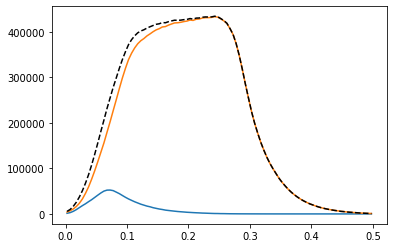

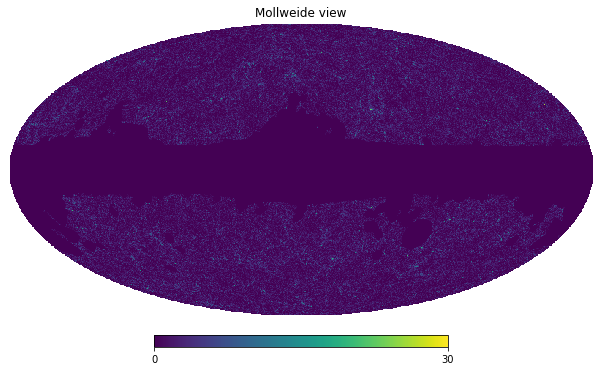

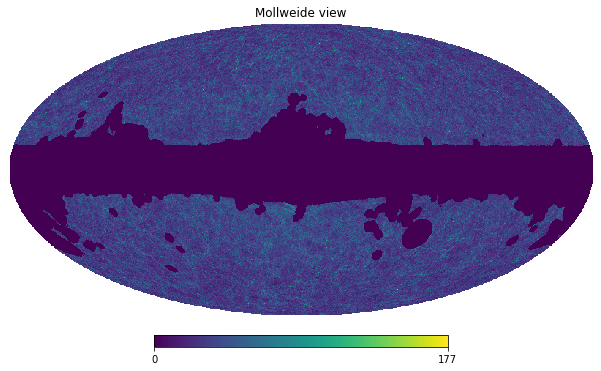

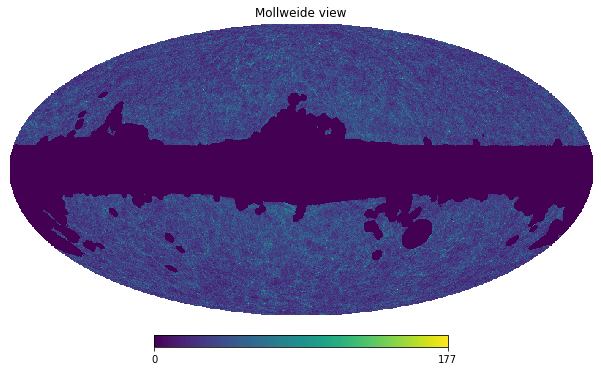

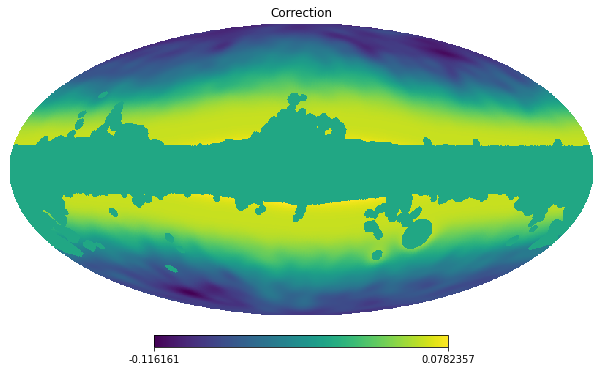

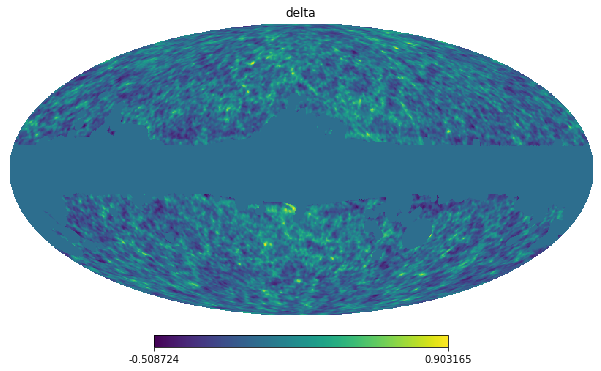

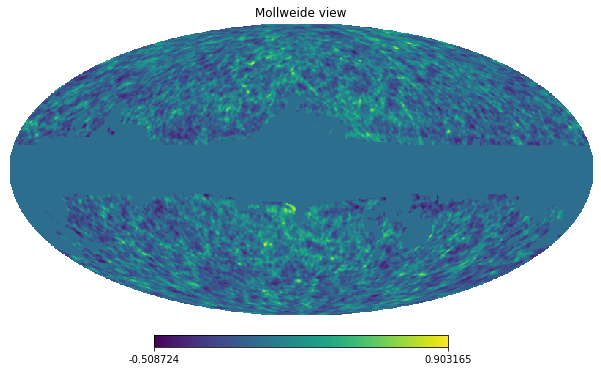

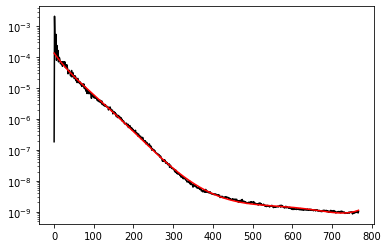

In [9]:
generate_delta_from_catalogs([d2mpz, dwisc], weighted=False, correct=True, smooth=1.,
                             prefix='WISC_2MPZ_smooth1p0_not_weighted_corrected')

setting the output map dtype to [dtype('float64')]


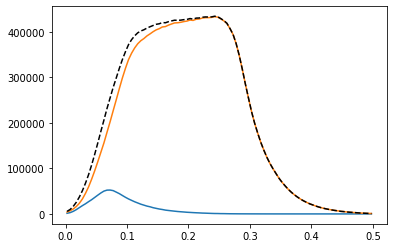

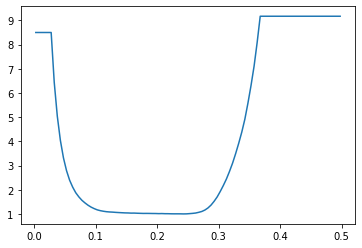

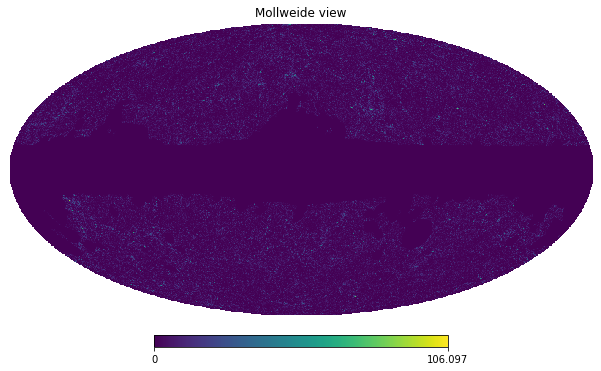

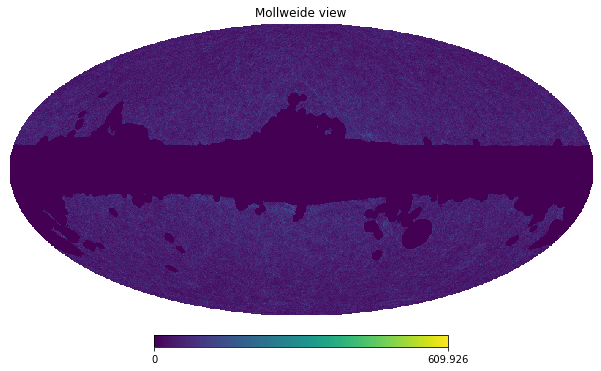

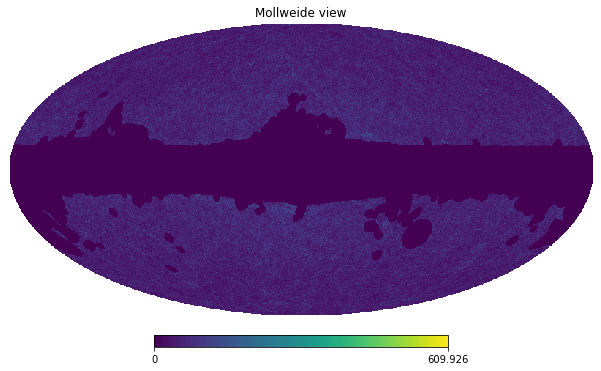

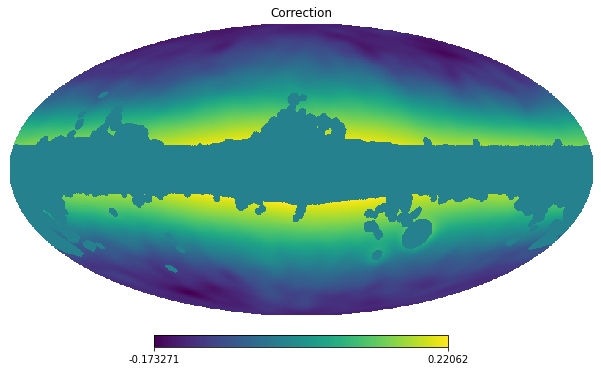

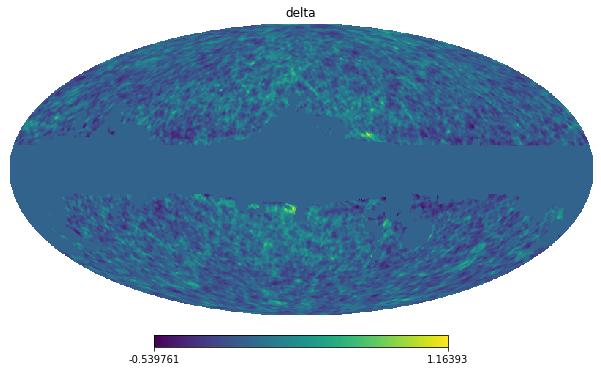

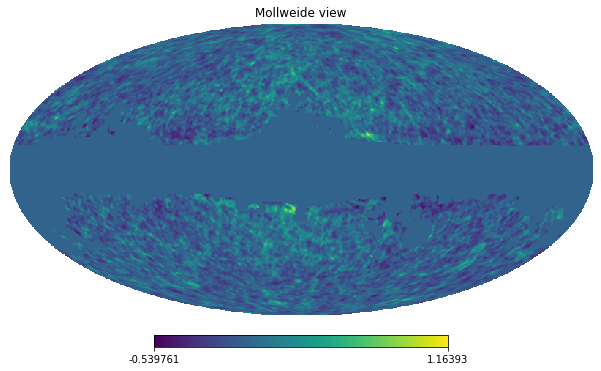

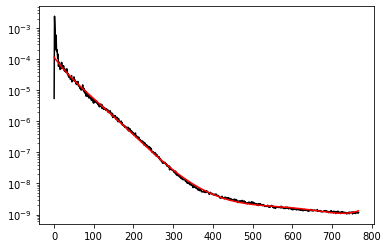

In [10]:
generate_delta_from_catalogs([d2mpz, dwisc], weighted=True, correct=True, smooth=1.,
                             prefix='WISC_2MPZ_smooth1p0_weighted_corrected')

setting the output map dtype to [dtype('float64')]


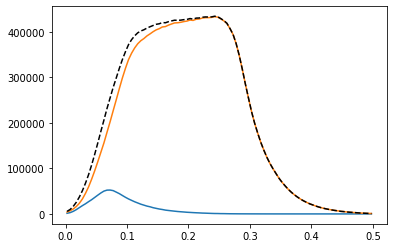

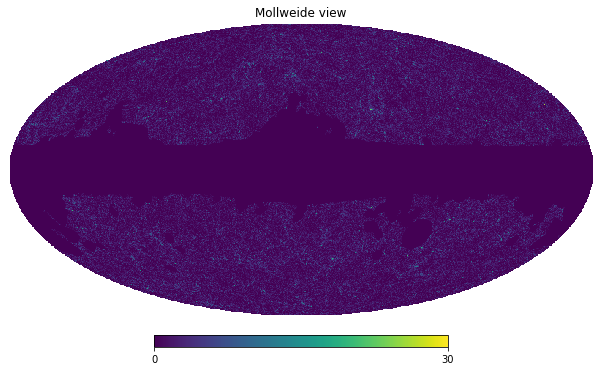

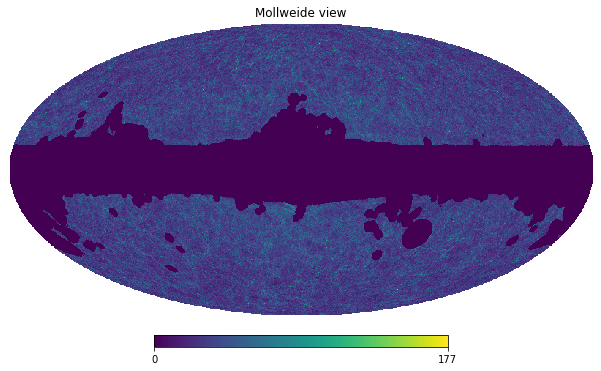

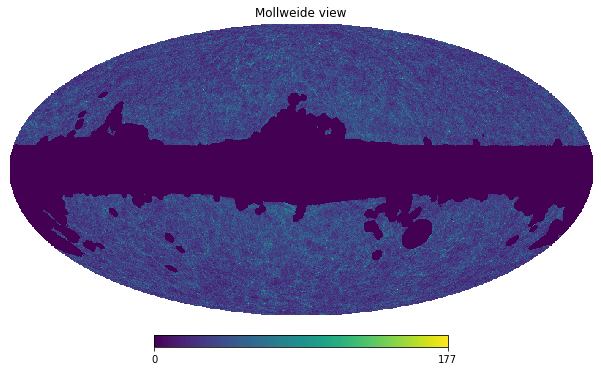

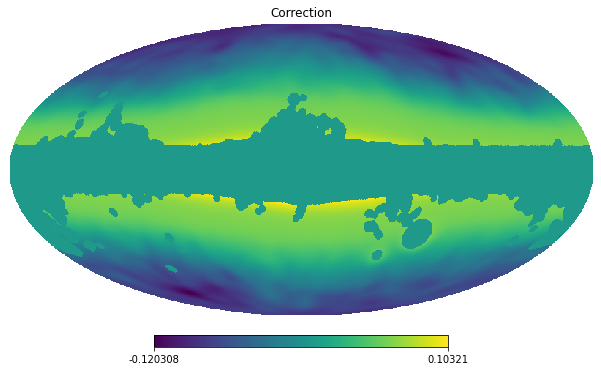

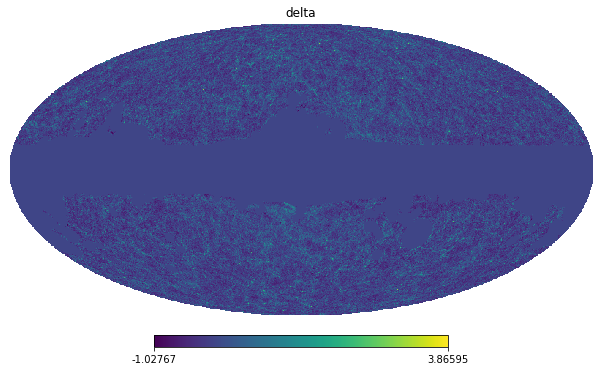

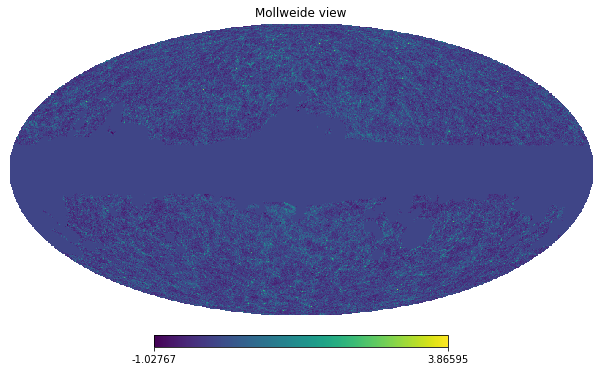

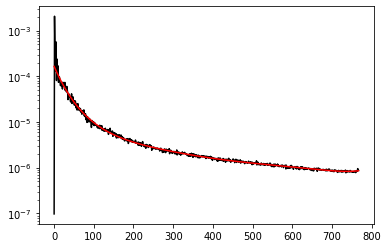

In [11]:
generate_delta_from_catalogs([d2mpz, dwisc], weighted=False, correct=True, smooth=None,
                             prefix='WISC_2MPZ_smooth0p0_not_weighted_corrected')

setting the output map dtype to [dtype('float64')]


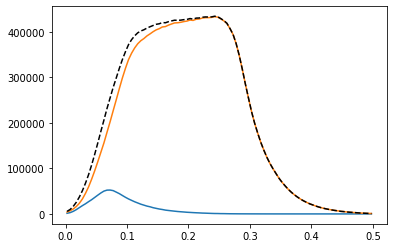

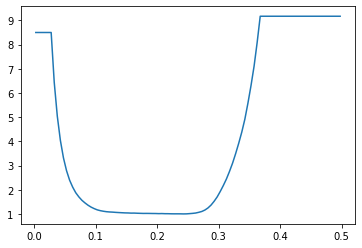

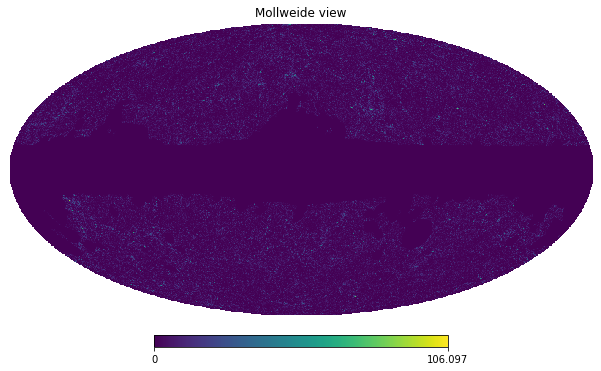

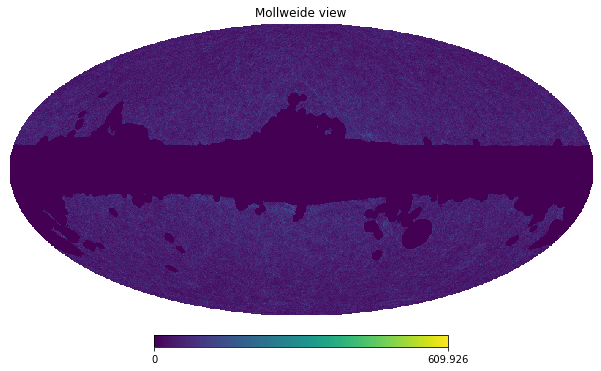

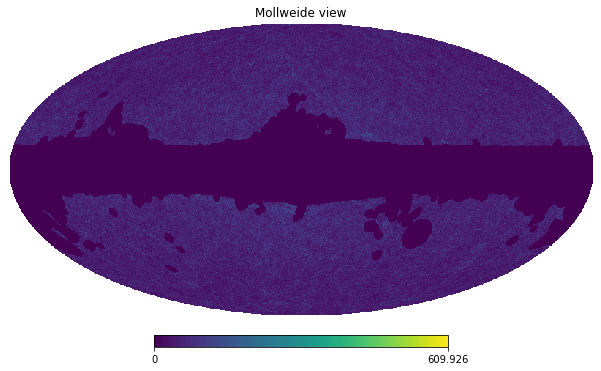

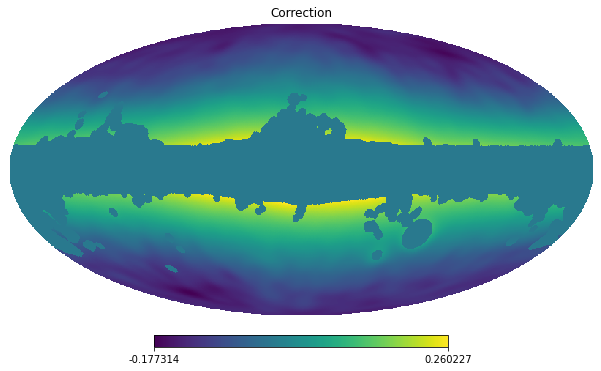

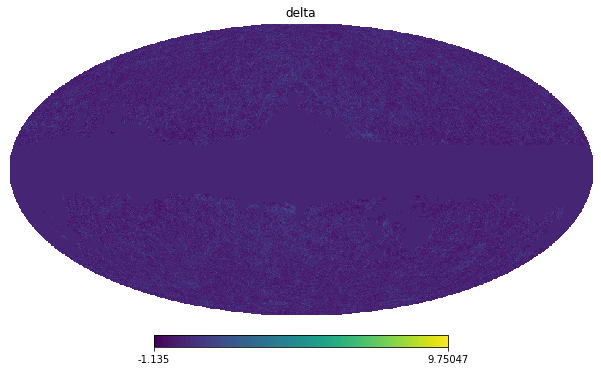

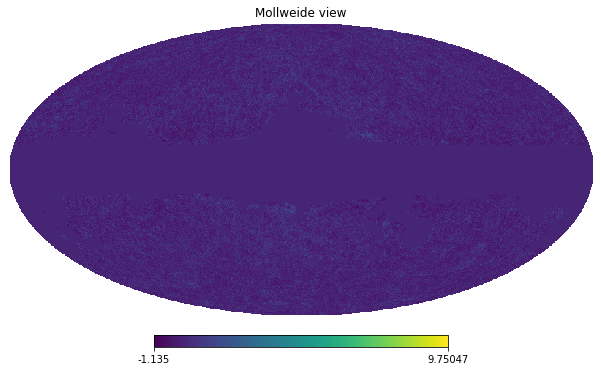

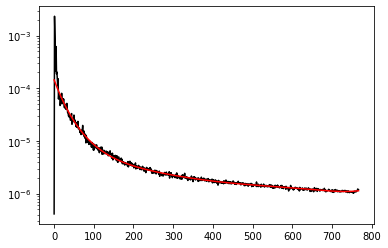

In [12]:
generate_delta_from_catalogs([d2mpz, dwisc], weighted=True, correct=True, smooth=None,
                             prefix='WISC_2MPZ_smooth0p0_weighted_corrected')

# Downgrading to a common resolution and computing covariance

In [13]:
from scipy.special import legendre

def downgrade_covar(prefix, nside_lo=8, mask_thr=0.7):
    # Read stuff
    delta_hi = hp.read_map(f'data/delta_{prefix}.fits.gz')
    cld = np.load(f'data/cl_{prefix}.npz')
    ls = cld['ls']
    cl = cld['cl']
    mask_hi = mask

    # Downgrade
    delta_lo = hp.ud_grade(delta_hi, nside_out=nside_lo)
    mask_lo = hp.ud_grade(mask_hi, nside_out=nside_lo)
    # Correct for area fraction in average
    pix_good = mask_lo > mask_thr
    delta_lo[pix_good] = delta_lo[pix_good]/mask_lo[pix_good]
    delta_lo[~pix_good] = 0
    mask_lo[pix_good] = 1
    mask_lo[~pix_good] = 0
    hp.mollview(delta_hi)
    hp.mollview(delta_lo)
    hp.mollview(mask_hi)
    hp.mollview(mask_lo)

    # Compute signal covariance
    npix_lo = delta_lo.size
    scov = np.zeros([npix_lo, npix_lo])
    u = np.array(hp.pix2vec(nside_lo, np.arange(npix_lo)))
    mu_ij = np.dot(u.T, u)
    for l in range(4*nside_lo):
        scov += cl[l]*(2*l+1)*legendre(l)(mu_ij)/(4*np.pi)
    # Let's calculate the standard deviation
    # and remove a bit to put as part of the noise
    sigma2 = np.mean(np.diag(scov))
    sig2n = 0.1*sigma2
    scov = scov - sig2n*np.eye(npix_lo)
    # Invert it
    sinv = np.linalg.inv(scov)

    # Compute inverse noise covariance
    ninv_diag = np.zeros(npix_lo)
    ninv_diag[pix_good] = 1./sig2n
    ninv = np.diag(ninv_diag)

    # Now compute inverse covariance:
    # C = (S+N) => C^-1 = N^-1 (N^-1+S^-1)^-1 S^-1
    sinv_ninv_inv = np.linalg.inv(ninv+sinv)
    cinv = np.dot(ninv, np.dot(sinv_ninv_inv, sinv))
    plt.figure(figsize=(10, 10))
    plt.imshow(sinv)
    plt.colorbar()
    plt.figure(figsize=(10, 10))
    plt.imshow(cinv)
    plt.colorbar()

    # Test second method
    ndiag = np.zeros(npix_lo)
    ndiag[~pix_good] = 1E200
    cov = scov + np.diag(ndiag)
    cinv2 = np.linalg.inv(cov)
    plt.figure(figsize=(10, 10))
    plt.imshow(cinv2)
    plt.colorbar()

    # Check eigenvalues
    w1, _ = np.linalg.eigh(sinv)
    w2, _ = np.linalg.eigh(cinv)
    w3, _ = np.linalg.eigh(cinv2)
    plt.figure()
    plt.plot(w1, 'r-')
    plt.plot(w2, 'b-')
    plt.plot(w3, 'y--')
    plt.yscale('log')

    # Save
    # Symmetrize first
    cinv = 0.5*(cinv+cinv.T)
    np.savez(f'data/map_cov_{prefix}.npz', map=delta_lo, inv_cov=cinv)

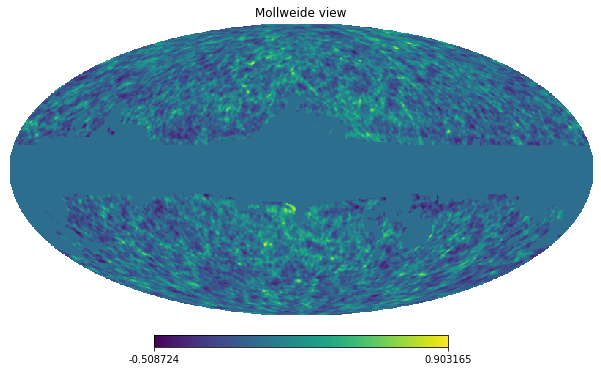

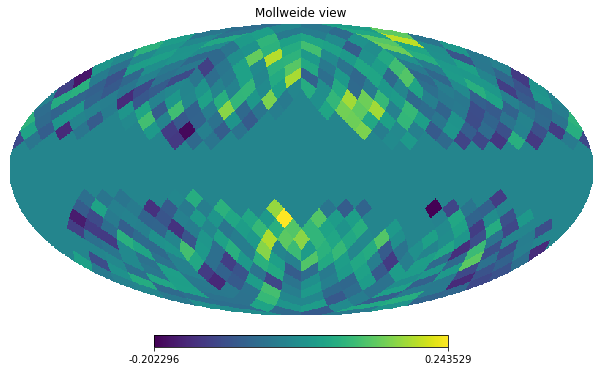

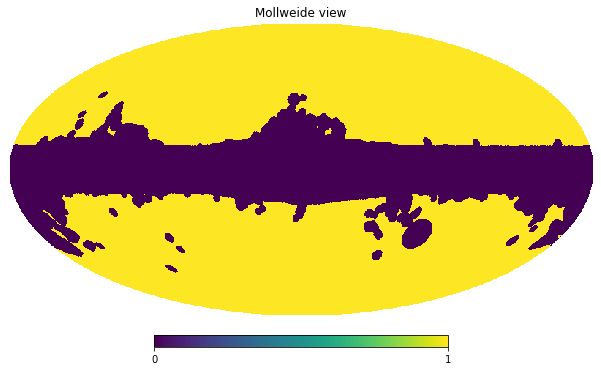

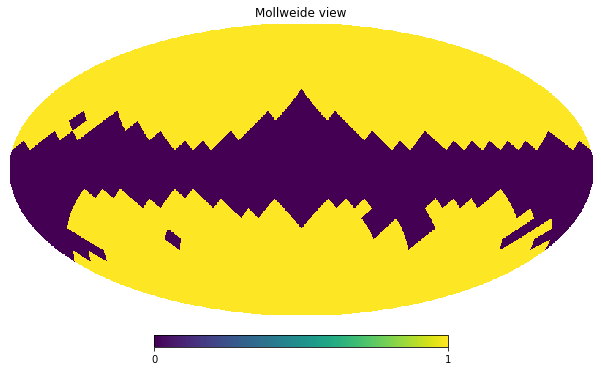

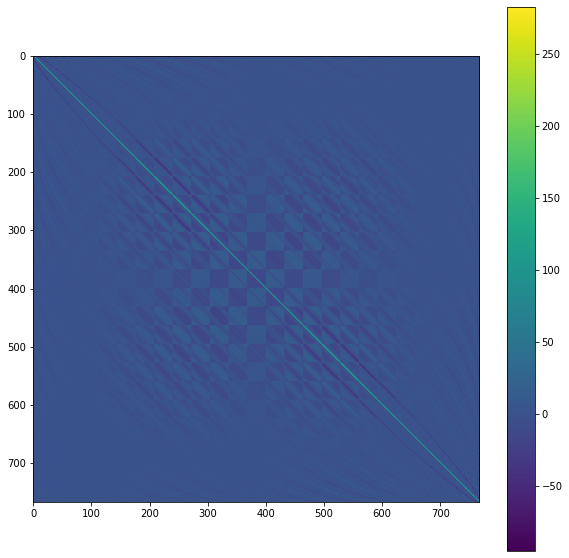

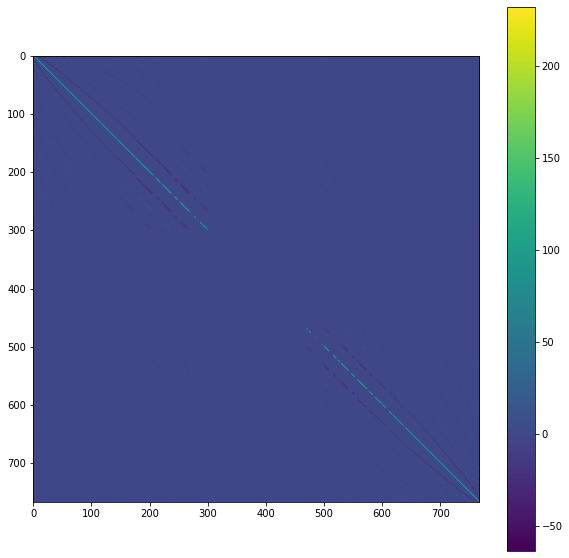

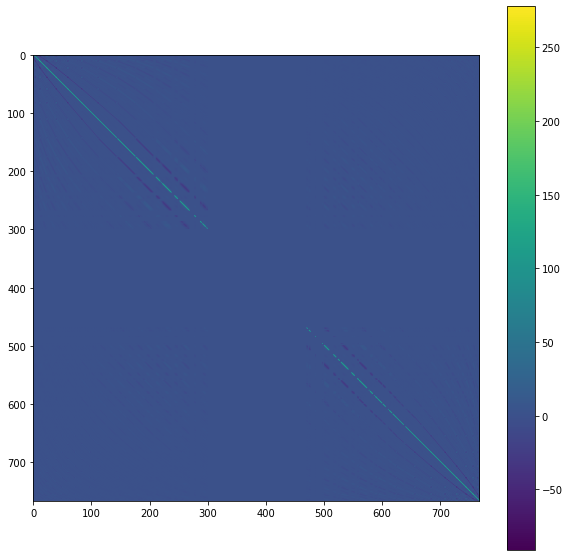

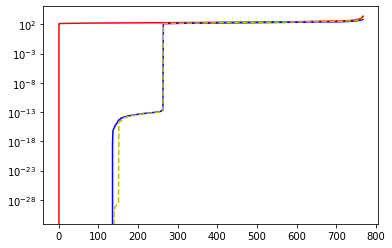

In [14]:
downgrade_covar('WISC_2MPZ_smooth1p0_not_weighted_corrected')

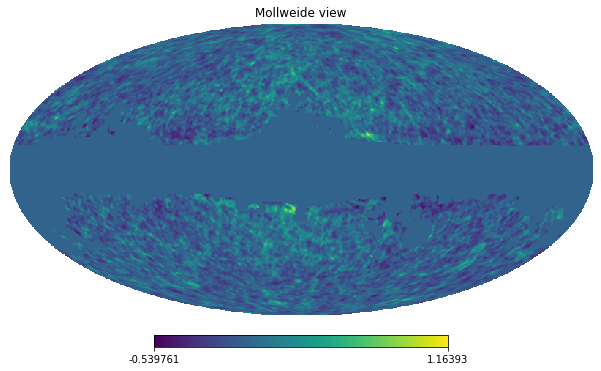

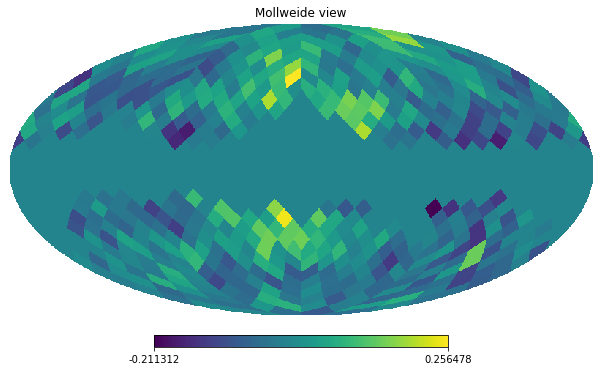

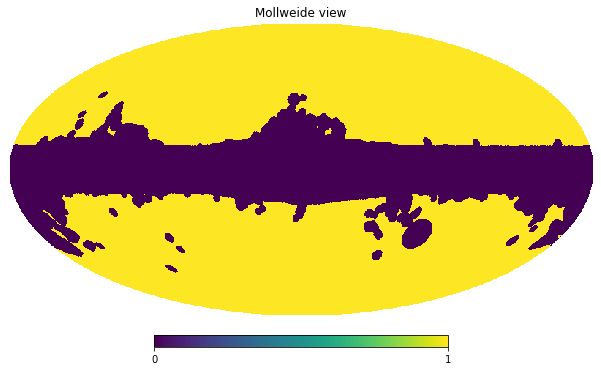

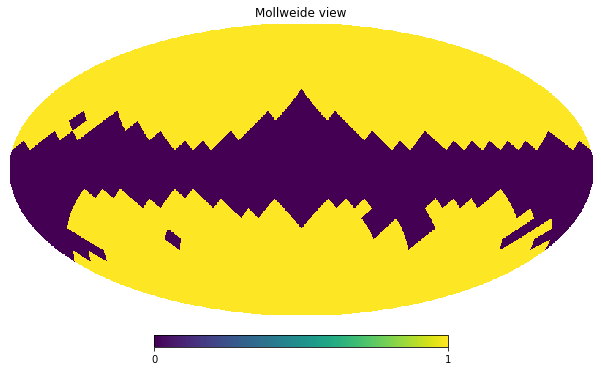

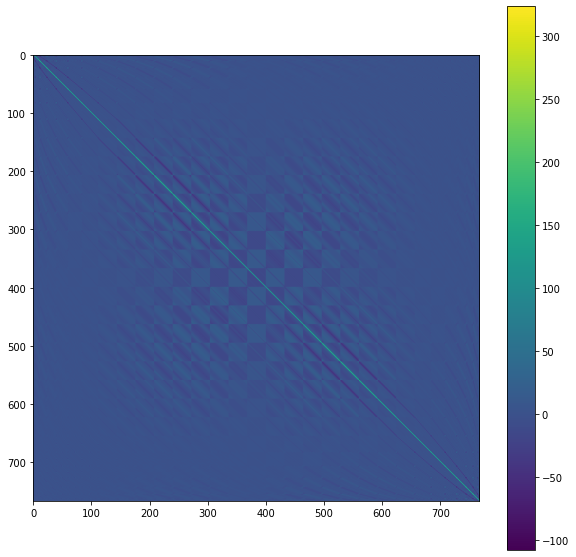

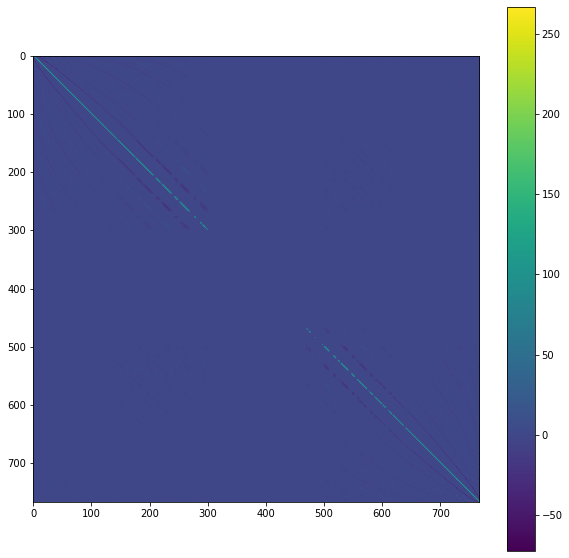

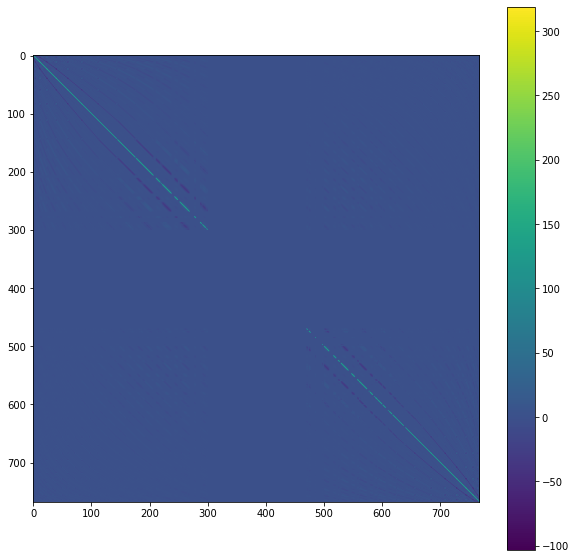

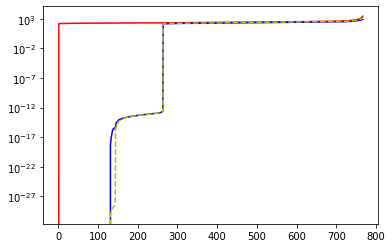

In [15]:
downgrade_covar('WISC_2MPZ_smooth1p0_weighted_corrected')